In [1]:
import torch
import torch.nn as nn
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from typing import List, Tuple, Union
import numpy as np
from itertools import zip_longest
from copy import deepcopy
import torch.optim as optim
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error
from collections import Counter
from torch_scatter import scatter_sum, scatter_mean
import logging
from rdkit import Chem
import math
from onmt.modules.embeddings import PositionalEncoding
from onmt.modules.position_ffn import PositionwiseFeedForward
from onmt.utils.misc import sequence_mask
import sys
sys.path.append("/home/chenlidong/polyAttn/models")
sys.path.append("/home/chenlidong/polyAttn/utils")
# import polygnn
sys.path.append("/home/chenlidong/polymer-chemprop-master/chemprop/")
import chem_utils
from sklearn.model_selection import KFold
import pdb
from torch.nn.utils.rnn import pad_sequence
from typing import List, Union, Tuple
from functools import reduce
from rdkit import Chem
import torch.nn.init as init
import networkx as nx
from args import TrainArgs
from features import mol2graph, BatchMolGraph, get_atom_fdim, get_bond_fdim
from nn_utils import get_activation_function, index_select_ND
import pandas as pd
from models import pyG_helper

/home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_geometric/typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: /lib64/libm.so.6: version `GLIBC_2.27' not found (required by /home/chenlidong/.conda/envs/py_38_torch_113_pyg/lib/python3.8/site-packages/torch_spline_conv/_basis_cuda.so)
  warnings.warn(


In [2]:
# import os
# os.environ["http_proxy"] = "socks5h://ucenter:1045"
# os.environ["https_proxy"] = "socks5h://ucenter:1045"
# os.environ["HTTP_PTOXY"] = "socks5h://ucenter:1045"
# os.environ["HTTPS_PTOXY"] = "socks5h://ucenter:1045"

In [3]:
torch.manual_seed(12138)
torch.cuda.manual_seed_all(12138)
np.random.seed(12138)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
Exp96_data = pd.read_csv("/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/96_homopolymer_MD_Exper.csv")
Exp96_data

,SMILES,Experiment Tg,MD Tg
0,*O[Si](CCCN=C1c2c(ccc(c2C(=NCCC[Si](*)(C)C)c2c...,7.50,51.30
1,*Oc1ccc(cc1)S(=O)(=O)c1ccc(cc1)Oc1ccc(cc1)C(c1...,219.29,255.52
2,*OP(=O)(N=Nc1ccc(cc1)COC(=O)c1cc(cc(c1)C(C)(C)...,62.00,62.39
3,*c1cc2c(C(=O)N(C2=O)c2c(ccc(c2)N2C(=O)c3c(C2=O...,218.00,264.06
4,*Nc1c(cc(cc1)NC(=O)c1ccc(cc1)NC(=O)CCCCCCCCCCC...,199.50,187.43
...,...,...,...
91,*Oc1ccc(cc1)C1(c2cc(ccc2c2ccc(cc12)[N+](=O)[O-...,197.00,195.71
92,*c1cc2c(C(=O)N(C2=O)c2c(cc(c(c2C)C(=O)c2cc(ccc...,280.00,280.09
93,*Oc1ccc(cc1)Oc1ccc(cc1)C(=O)c1cc(ccc1)NC(=O)c1...,202.00,222.22
94,*Oc1ccc(cc1)CC(NC(=O)CCc1ccc(cc1)OC(=O)CCCC(=O...,21.00,42.34


In [5]:
np.mean(Exp96_data['MD Tg'])

157.34052083333333

In [6]:
model_info_attn = torch.load('/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/checkpoints/chemprop_checkpoints_polygnn_attn/Egc_aug/0/13256/fold_0/model_0/model.pt',map_location=torch.device('cuda'))

In [7]:
model_info = torch.load('/home/chenlidong/polymer-chemprop-master/data/polymer-chemprop-data-main/homopolymer/checkpoints/chemprop_checkpoints_polygnn/Egc_aug/0/13256/fold_0/model_0/model.pt',map_location=torch.device('cuda'))

In [8]:
args = model_info['args']
state_dict = model_info['state_dict']
state_dict.pop('ffn.4.bias')
state_dict.pop('ffn.4.weight')
state_dict.pop('ffn.1.bias')
state_dict.pop('ffn.1.weight')

tensor([[ 0.1081,  0.0177, -0.0244,  ...,  0.0314, -0.0428, -0.0374],
        [-0.0087, -0.0670, -0.0858,  ..., -0.0277,  0.0399,  0.0304],
        [-0.0808,  0.0795,  0.0394,  ..., -0.0865,  0.0339,  0.0107],
        ...,
        [ 0.0184, -0.0504, -0.1099,  ...,  0.0868, -0.0550, -0.0698],
        [-0.0205, -0.0967,  0.0546,  ...,  0.0305, -0.0749, -0.0475],
        [-0.0510,  0.0469,  0.1060,  ...,  0.0626, -0.0098, -0.0546]],
       device='cuda:0')

In [9]:
args_attn = model_info_attn['args']
state_dict_attn = model_info_attn['state_dict']
state_dict_attn.pop('ffn.4.bias')
state_dict_attn.pop('ffn.4.weight')
state_dict_attn.pop('ffn.1.bias')
state_dict_attn.pop('ffn.1.weight')

tensor([[ 0.1052, -0.0824,  0.0079,  ...,  0.0807,  0.0692, -0.0988],
        [-0.0629,  0.0742,  0.0655,  ...,  0.0661, -0.0134, -0.0244],
        [ 0.0101,  0.0410, -0.0922,  ...,  0.0437,  0.0267, -0.0147],
        ...,
        [ 0.0990,  0.0389, -0.0311,  ..., -0.0395, -0.0364, -0.0582],
        [ 0.0248,  0.0879,  0.0449,  ...,  0.0824,  0.0123, -0.0082],
        [-0.0583,  0.0401, -0.0454,  ..., -0.0355,  0.0880,  0.0982]],
       device='cuda:0')

In [10]:
from collections import OrderedDict
filtered_dict = OrderedDict((key[18:], value) for key, value in state_dict.items())
filtered_dict_attn = OrderedDict((key[18:], value) for key, value in state_dict_attn.items())

In [11]:
encoder_model = pyG_helper(args,133,147)
encoder_model_attn = pyG_helper(args_attn,133,147)

In [12]:
encoder_model.load_state_dict(filtered_dict, strict=True)
encoder_model_attn.load_state_dict(filtered_dict_attn,strict=True)

<All keys matched successfully>

In [13]:
encoder_model.to("cuda")
encoder_model_attn.to("cuda")
encoder_model.eval()
encoder_model_attn.eval()
print(1)

1


In [16]:
# import wandb
# wandb.init(
#     # set the wandb project where this run will be logged
#     project="pretrain-fineturning",
#     name="GATech_6k_Egc_pretrain--ACS_96_Tg_fineturning",
#     # track hyperparameters and run metadata
#     config={
#         "epochs": 300,
#         "lr": 0.001,
#     }
# )

In [17]:
class MLP(nn.Module):
    def __init__(self, hidden_size1, hidden_size2,act,dropout,init,batch_norm):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(256, hidden_size1)
        self.act1 = act
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.act2 = act
        self.fc3 = nn.Linear(hidden_size2, 1)
        self.bn2 = nn.BatchNorm1d(hidden_size2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.init = init
        self.batch_norm = batch_norm
        self.initialize_parameters()


    def forward(self, x):
        x = self.fc1(x)
        if self.batch_norm:
            x = self.bn1(x)
        x = self.act1(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        if self.batch_norm:
            x = self.bn2(x)
        x = self.act2(x)
        x = self.dropout2(x)

        x = self.fc3(x)
        return x

    def initialize_parameters(self):
        for layer in self.modules():
            if isinstance(layer, nn.Linear):
                if self.init == "constant":
                    init.zeros_(layer.weight)
                elif self.init == "xavier_uniform":
                    init.xavier_uniform_(layer.weight)
                elif self.init == "xavier_normal":
                    init.xavier_normal_(layer.weight)
                elif self.init == "kaiming_uniform":
                    init.kaiming_uniform_(layer.weight)
                elif self.init == "kaiming_normal":
                    init.kaiming_normal_(layer.weight)
                init.zeros_(layer.bias)
            elif isinstance(layer, nn.BatchNorm1d):
                init.ones_(layer.weight)
                init.zeros_(layer.bias)

In [33]:
from sklearn.model_selection import train_test_split
def get_data(random_state,with_attn):
    train_df, test_df = train_test_split(Exp96_data, test_size=0.2, random_state=random_state)
    train_data = train_df.SMILES.to_list()
    test_data = test_df.SMILES.to_list()
    # print(len(train_data))
    # print(len(test_data))
    train_batch_mol2graph = mol2graph(train_data,[0 for i in range(len(train_data))],[0 for i in range(len(train_data))])
    test_batch_mol2graph = mol2graph(test_data,[0 for i in range(len(test_data))],[0 for i in range(len(test_data))])
    train_embedding = encoder_model(train_batch_mol2graph).detach()
    train_embedding_attn = encoder_model_attn(train_batch_mol2graph).detach()
    test_embedding = encoder_model(test_batch_mol2graph).detach()
    test_embedding_attn = encoder_model_attn(test_batch_mol2graph).detach()
    train_output_tensor = torch.tensor(train_df['Experiment Tg'].to_list(),device="cuda")
    test_output_tensor = torch.tensor(test_df['Experiment Tg'].to_list(),device="cuda")
    if with_attn:
        return train_embedding_attn,test_embedding_attn,train_output_tensor,test_output_tensor.cpu().detach().numpy()
    else:
        return train_embedding,test_embedding,train_output_tensor,test_output_tensor.cpu().detach().numpy()

In [34]:
data_list = [
    [
        get_data(111,False),
        get_data(112,False),
        get_data(113,False),
    ],
    [
        get_data(111,True),
        get_data(112,True),
        get_data(113,True),
    ]
]

In [35]:
from sklearn.model_selection import ParameterGrid
param_grid = {
    'hidden_size_0': [64, 256, 512, 1024],
    'hidden_size_1': [64, 256, 512, 1024],
    'learning_rate': [0.001, 0.01],
    'act': [nn.ReLU(),nn.Sigmoid(),nn.Tanh()],
    "dropout": [0.1,0.3,0.5],
    'init':["xavier_uniform",'xavier_normal','kaiming_uniform','kaiming_normal'],
    'batch_norm':[True,False]
    
}
# 4 * 4 * 2 * 3 * 3 * 4 * 2

In [36]:
params_and_results = []
min_r2 = 0
min_rmse = 10000

cur_data_list = data_list[1]                        #第一维度是0表示不用attn

for idx,params in enumerate(ParameterGrid(param_grid)):
    r2 = 0
    rmse = 0
    for i in range(3):
        target_np = cur_data_list[i][3]              
        mlp = MLP(params['hidden_size_0'],params['hidden_size_1'],params['act'],params['dropout'],params['init'],params['batch_norm'])
        mlp.to("cuda")
        mlp.train()
        criterion = nn.L1Loss()
        optimizer = optim.Adam(mlp.parameters(),lr=params['learning_rate'])
        num_epochs = 500
        for epoch in range(num_epochs):
            mlp.zero_grad()
            # Forward pass
            output_predictions = mlp(cur_data_list[i][0])
            
            # 计算损失
            loss = criterion(output_predictions.squeeze(), cur_data_list[i][2])
            loss.backward()
            optimizer.step()

        mlp.eval()
        preds = mlp(cur_data_list[i][1])
        preds_np = preds.cpu().detach().numpy()
        r2 += r2_score(target_np, preds_np)
        rmse += np.sqrt(mean_squared_error(target_np, preds_np))
    
    rmse = rmse/3
    r2 = r2/3
    if rmse < min_rmse:
        min_rmse = rmse
        print(f"找到更小的rmse      {rmse}")
        print(params)
    
    param_and_result = {
        'r2': r2,
        'rmse': rmse,
        'hyperparameters': params
    }
    if rmse < 65:
        params_and_results.append(param_and_result)
    if (idx+1)%100 == 0:
        print(f"当前idx:   {idx+1}")


找到更小的rmse      158.91602071126303
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.1, 'hidden_size_0': 64, 'hidden_size_1': 64, 'init': 'xavier_uniform', 'learning_rate': 0.001}
找到更小的rmse      81.67825571695964
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.1, 'hidden_size_0': 64, 'hidden_size_1': 64, 'init': 'xavier_uniform', 'learning_rate': 0.01}
找到更小的rmse      78.0714619954427
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.1, 'hidden_size_0': 64, 'hidden_size_1': 64, 'init': 'xavier_normal', 'learning_rate': 0.01}
找到更小的rmse      72.64037068684895
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.1, 'hidden_size_0': 64, 'hidden_size_1': 512, 'init': 'kaiming_normal', 'learning_rate': 0.001}
当前idx:   100
找到更小的rmse      72.3272196451823
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.3, 'hidden_size_0': 64, 'hidden_size_1': 512, 'init': 'xavier_uniform', 'learning_rate': 0.001}
找到更小的rmse      70.99707285563152
{'act': ReLU(), 'batch_norm': True, 'dropout': 0.3, 'hidden_size_0': 64

In [74]:
params_and_results

[]

# 以下为训练代码

In [14]:
data = Exp96_data.SMILES.to_list()
batch_mol2graph = mol2graph(data,[0 for i in range(len(data))],[0 for i in range(len(data))])
embedding = encoder_model(batch_mol2graph).detach()
embedding_attn = encoder_model_attn(batch_mol2graph).detach()
output_tensor = torch.tensor(Exp96_data['MD Tg'].to_list(),device="cuda")

In [18]:
r2s = []
rmses = []
for i in range(5):
    kf = KFold(n_splits=5, shuffle=True, random_state=i+3)
    for fold, (train_index, val_index) in enumerate(kf.split(embedding)):
        print(f"Fold {fold + 1}")

        train_data = embedding[train_index]
        train_y = output_tensor[train_index]
        test_data = embedding[val_index]
        test_y = output_tensor[val_index].cpu()

        mlp = MLP(64,1024,nn.ReLU(),0.1,"kaiming_uniform",False)
        mlp.train()
        mlp.to("cuda")
        criterion = nn.L1Loss()
        optimizer = optim.Adam(mlp.parameters(),lr=0.001)
        num_epochs = 500
        for epoch in range(num_epochs):
            mlp.zero_grad()
            # Forward pass
            output_predictions = mlp(train_data)
            
            # 计算损失
            loss = criterion(output_predictions.squeeze(), train_y)
            # wandb.log({"train-loss": loss.detach().cpu().numpy()})
            loss.backward()
            optimizer.step()
            # if (epoch+1)%100 == 0:
            #     print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')
                
        mlp.eval()
        preds = mlp(test_data)
        preds_np = preds.cpu().detach().numpy()
        r2s.append(r2_score(test_y, preds_np))
        rmses.append(np.sqrt(mean_squared_error(test_y, preds_np)))
        print(f'R2 Score: {r2_score(test_y, preds_np):.4f}')
        print(f'RMSE: {np.sqrt(mean_squared_error(test_y, preds_np)):.4f}')
        print()
print(f"RMSE: {np.mean(rmses)}±{np.std(rmses)}")
print(f"R2: {np.mean(r2s)}±{np.std(r2s)}")

Fold 1
R2 Score: 0.5480
RMSE: 66.8227

Fold 2
R2 Score: 0.1677
RMSE: 93.9702

Fold 3
R2 Score: 0.7746
RMSE: 57.5604

Fold 4
R2 Score: 0.7907
RMSE: 53.9034

Fold 5
R2 Score: 0.5861
RMSE: 71.2874

Fold 1
R2 Score: 0.6259
RMSE: 80.3665

Fold 2
R2 Score: 0.1867
RMSE: 83.9287

Fold 3
R2 Score: 0.5113
RMSE: 72.7045

Fold 4
R2 Score: 0.7052
RMSE: 61.2652

Fold 5
R2 Score: 0.6369
RMSE: 63.4255

Fold 1
R2 Score: 0.6623
RMSE: 68.5719

Fold 2
R2 Score: 0.6664
RMSE: 65.3627

Fold 3
R2 Score: 0.7224
RMSE: 63.1151

Fold 4
R2 Score: 0.6661
RMSE: 51.6894

Fold 5
R2 Score: 0.4709
RMSE: 75.6482

Fold 1
R2 Score: 0.6115
RMSE: 86.4206

Fold 2
R2 Score: 0.5665
RMSE: 71.5823

Fold 3
R2 Score: 0.5723
RMSE: 67.6713

Fold 4
R2 Score: 0.5697
RMSE: 65.1757

Fold 5
R2 Score: 0.7007
RMSE: 51.2142

Fold 1
R2 Score: 0.6790
RMSE: 64.2823

Fold 2
R2 Score: 0.7566
RMSE: 55.9435

Fold 3
R2 Score: 0.5296
RMSE: 73.0063

Fold 4
R2 Score: 0.3545
RMSE: 78.6757

Fold 5
R2 Score: 0.4748
RMSE: 76.8327

RMSE: 68.81705474853516±1

In [19]:
r2s = []
rmses = []
for i in range(5):
    kf = KFold(n_splits=5, shuffle=True, random_state=i+3)
    for fold, (train_index, val_index) in enumerate(kf.split(embedding_attn)):
        print(f"Fold {fold + 1}")

        train_data = embedding_attn[train_index]
        train_y = output_tensor[train_index]
        test_data = embedding_attn[val_index]
        test_y = output_tensor[val_index].cpu()

        mlp_attn = MLP(64,512,nn.Sigmoid(),0.1,'xavier_uniform', True)
        mlp_attn.train()
        mlp_attn.to("cuda")
        criterion = nn.L1Loss()
        optimizer = optim.Adam(mlp_attn.parameters(),lr=0.001)
        num_epochs = 500
        for epoch in range(num_epochs):
            mlp_attn.zero_grad()
            output_predictions = mlp_attn(train_data)
            loss = criterion(output_predictions.squeeze(), train_y)
            loss.backward()
            optimizer.step()

        mlp_attn.eval()
        preds = mlp_attn(test_data)
        preds_np = preds.cpu().detach().numpy()
        r2s.append(r2_score(test_y, preds_np))
        rmses.append(np.sqrt(mean_squared_error(test_y, preds_np)))
        print(f'R2 Score: {r2_score(test_y, preds_np):.4f}')
        print(f'RMSE: {np.sqrt(mean_squared_error(test_y, preds_np)):.4f}')
        print()
print(f"RMSE: {np.mean(rmses)}±{np.std(rmses)}")
print(f"R2: {np.mean(r2s)}±{np.std(r2s)}")


Fold 1
R2 Score: 0.5069
RMSE: 69.7930

Fold 2
R2 Score: 0.3920
RMSE: 80.3159

Fold 3
R2 Score: 0.5069
RMSE: 85.1385

Fold 4
R2 Score: 0.5531
RMSE: 78.7653

Fold 5
R2 Score: 0.5537
RMSE: 74.0257

Fold 1
R2 Score: 0.4302
RMSE: 99.1866

Fold 2
R2 Score: 0.5099
RMSE: 65.1495

Fold 3
R2 Score: 0.3336
RMSE: 84.8984

Fold 4
R2 Score: 0.6053
RMSE: 70.8903

Fold 5
R2 Score: 0.4022
RMSE: 81.3837

Fold 1
R2 Score: 0.4613
RMSE: 86.6057

Fold 2
R2 Score: 0.4636
RMSE: 82.8832

Fold 3
R2 Score: 0.4704
RMSE: 87.1718

Fold 4
R2 Score: 0.4646
RMSE: 65.4534

Fold 5
R2 Score: 0.3631
RMSE: 82.9983

Fold 1
R2 Score: 0.4778
RMSE: 100.1849

Fold 2
R2 Score: 0.4548
RMSE: 80.2785

Fold 3
R2 Score: 0.4705
RMSE: 75.2946

Fold 4
R2 Score: 0.4253
RMSE: 75.3244

Fold 5
R2 Score: 0.5955
RMSE: 59.5389

Fold 1
R2 Score: 0.6335
RMSE: 68.6816

Fold 2
R2 Score: 0.4178
RMSE: 86.5141

Fold 3
R2 Score: 0.4332
RMSE: 80.1392

Fold 4
R2 Score: 0.2566
RMSE: 84.4334

Fold 5
R2 Score: 0.3320
RMSE: 86.6519

RMSE: 79.66802978515625±

In [ ]:
# mlp.eval()
# mlp_attn.eval()
# preds = mlp(test_embedding)
# preds_attn = mlp_attn(test_embedding_attn)


# # Assuming preds and target are your tensors
# # Convert them to numpy arrays
# preds_np = preds.cpu().detach().numpy()
# preds_attn_np = preds_attn.cpu().detach().numpy()

# # print(test_output_tensor)
# # print(preds_np)
# print(f'R2 Score: {r2_score(test_output_tensor, preds_np):.4f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(test_output_tensor, preds_np)):.4f}')

# print(f'Attn R2 Score: {r2_score(test_output_tensor_attn, preds_attn_np):.4f}')
# print(f'Attn RMSE: {np.sqrt(mean_squared_error(test_output_tensor_attn, preds_attn_np)):.4f}')

In [44]:
embedding_df,embedding_attn_df,output_df =  embedding.cpu().detach().numpy(),\
                                            embedding_attn.cpu().detach().numpy(),\
                                            output_tensor.cpu().detach().numpy(),\
                                            

In [45]:
from sklearn.ensemble import RandomForestRegressor
r2s = []
rmses = []
for i in range(5):
    kf = KFold(n_splits=5, shuffle=True, random_state=i)
    for fold, (train_index, val_index) in enumerate(kf.split(embedding_df)):
        print(f"Fold {fold + 1}")

        train_data = embedding_df[train_index]
        train_y = output_df[train_index]
        test_data = embedding_df[val_index]
        test_y = output_df[val_index]

        # rf_regressor = RandomForestRegressor(n_estimators=100, max_depth = 10,min_samples_split = 2,random_state=0)
        rf_regressor = RandomForestRegressor(n_estimators=200,random_state=0)
        rf_regressor.fit(train_data, train_y)

        y_pred = rf_regressor.predict(test_data)

        r2s.append(r2_score(test_y, y_pred))
        rmses.append(np.sqrt(mean_squared_error(test_y, y_pred)))
        print(f'R2 Score: {r2_score(test_y, y_pred):.4f}')
        print(f'RMSE: {np.sqrt(mean_squared_error(test_y, y_pred)):.4f}')
        print()
print(f"RMSE: {np.mean(rmses)}±{np.std(rmses)}")
print(f"R2: {np.mean(r2s)}±{np.std(r2s)}")


Fold 1
R2 Score: 0.4414
RMSE: 76.7144

Fold 2
R2 Score: 0.8073
RMSE: 45.7678

Fold 3
R2 Score: 0.5561
RMSE: 77.4380

Fold 4
R2 Score: 0.5909
RMSE: 60.4289

Fold 5
R2 Score: 0.4090
RMSE: 82.1294

Fold 1
R2 Score: 0.6344
RMSE: 70.6380

Fold 2
R2 Score: 0.3381
RMSE: 77.5047

Fold 3
R2 Score: 0.2973
RMSE: 74.7743

Fold 4
R2 Score: 0.7371
RMSE: 63.5831

Fold 5
R2 Score: 0.5769
RMSE: 69.9510

Fold 1
R2 Score: 0.4455
RMSE: 78.9699

Fold 2
R2 Score: 0.6774
RMSE: 67.6313

Fold 3
R2 Score: 0.5778
RMSE: 83.3089

Fold 4
R2 Score: 0.6033
RMSE: 52.0816

Fold 5
R2 Score: 0.2192
RMSE: 76.6075

Fold 1
R2 Score: 0.4986
RMSE: 75.0845

Fold 2
R2 Score: 0.1330
RMSE: 88.2763

Fold 3
R2 Score: 0.6905
RMSE: 68.6321

Fold 4
R2 Score: 0.7986
RMSE: 47.6643

Fold 5
R2 Score: 0.4555
RMSE: 78.5366

Fold 1
R2 Score: 0.6541
RMSE: 72.8654

Fold 2
R2 Score: 0.5035
RMSE: 63.1226

Fold 3
R2 Score: 0.5123
RMSE: 71.1253

Fold 4
R2 Score: 0.7229
RMSE: 55.6651

Fold 5
R2 Score: 0.5078
RMSE: 78.8221

RMSE: 70.29292833427893±1

In [46]:
from sklearn.ensemble import RandomForestRegressor
r2s = []
rmses = []
for i in range(5):

    kf = KFold(n_splits=5, shuffle=True, random_state=i+23232)
    for fold, (train_index, val_index) in enumerate(kf.split(embedding_attn_df)):
        print(f"Fold {fold + 1}")

        train_data = embedding_attn_df[train_index]
        train_y = output_df[train_index]
        test_data = embedding_attn_df[val_index]
        test_y = output_df[val_index]

        # rf_regressor = RandomForestRegressor(n_estimators=100, max_depth = 10,min_samples_split=2,random_state=0)
        rf_regressor = RandomForestRegressor(n_estimators=200,random_state=92)
        rf_regressor.fit(train_data, train_y)

        y_pred = rf_regressor.predict(test_data)

        r2s.append(r2_score(test_y, y_pred))
        rmses.append(np.sqrt(mean_squared_error(test_y, y_pred)))
        print(f'R2 Score: {r2_score(test_y, y_pred):.4f}')
        print(f'RMSE: {np.sqrt(mean_squared_error(test_y, y_pred)):.4f}')
        print()
print(f"RMSE: {np.mean(rmses)}±{np.std(rmses)}")
print(f"R2: {np.mean(r2s)}±{np.std(r2s)}")

Fold 1
R2 Score: 0.2376
RMSE: 74.5680

Fold 2
R2 Score: 0.3856
RMSE: 83.5768

Fold 3
R2 Score: 0.3555
RMSE: 93.1588

Fold 4
R2 Score: 0.2380
RMSE: 81.3216

Fold 5
R2 Score: 0.5039
RMSE: 81.0825

Fold 1
R2 Score: 0.5821
RMSE: 72.4487

Fold 2
R2 Score: 0.5367
RMSE: 75.7119

Fold 3
R2 Score: 0.3895
RMSE: 88.3165

Fold 4
R2 Score: 0.6630
RMSE: 64.2870

Fold 5
R2 Score: 0.1213
RMSE: 82.3928

Fold 1
R2 Score: 0.2765
RMSE: 85.7806

Fold 2
R2 Score: 0.3552
RMSE: 83.1966

Fold 3
R2 Score: 0.7147
RMSE: 52.3789

Fold 4
R2 Score: 0.3728
RMSE: 70.5732

Fold 5
R2 Score: 0.5065
RMSE: 77.5503

Fold 1
R2 Score: 0.3120
RMSE: 85.1285

Fold 2
R2 Score: 0.2843
RMSE: 75.9534

Fold 3
R2 Score: 0.2582
RMSE: 63.0474

Fold 4
R2 Score: 0.5145
RMSE: 83.6684

Fold 5
R2 Score: 0.6823
RMSE: 73.9774

Fold 1
R2 Score: 0.2963
RMSE: 85.0365

Fold 2
R2 Score: 0.3206
RMSE: 74.0258

Fold 3
R2 Score: 0.6524
RMSE: 68.1144

Fold 4
R2 Score: 0.3870
RMSE: 76.9660

Fold 5
R2 Score: 0.5783
RMSE: 81.6939

RMSE: 77.3582427339725±8.

TypeError: unsupported operand type(s) for /: 'tuple' and 'int'

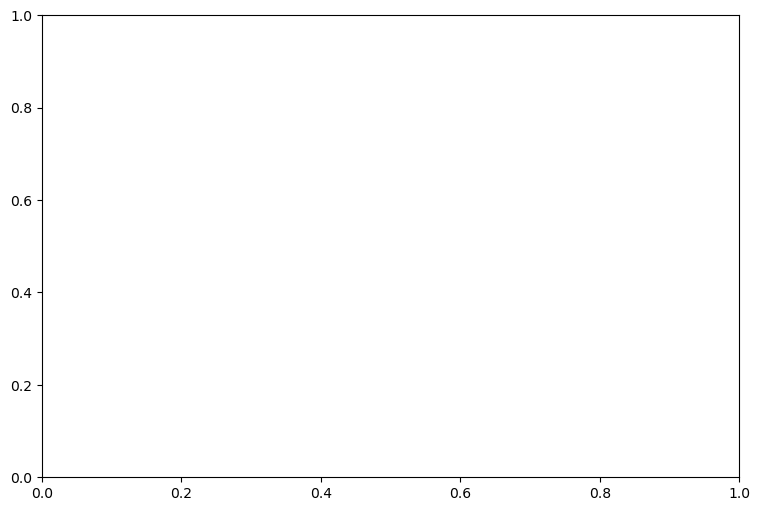

In [19]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1)
y1 = np.array([48.45])
y2 = np.array([45.83])
y3 = np.array([38.82])
y4 = np.array([43.08])
y5 = np.array([40.96])
y6 = np.array([48.14])
y7 = np.array([45.10])
# error1 = np.array([0.009032822080127123, 0.011587713046179957, 0.015625964008875642])
# error3 = np.array([0.008497797562251209,0.022710985401212178,0.04273997999140413])
# error4 = np.array([0.02,0.01,0.07])
# error2 = np.array([0.0057827329179203895, 0.007709734106958559, 0.03719354782754663])


bar_width = 0.175

fig, ax = plt.subplots(figsize=(9,6))
# rects1 = ax.bar(x - bar_width*2, y1, bar_width, yerr=error1, capsize=5, label='original',color=(177/255,24/255,45/255))
# rects2 = ax.bar(x - bar_width, y3, bar_width, yerr=error3, capsize=5, label='pretrain+MLP',color=(36/255,100/255,171/255))
# rects3 = ax.bar(x , y4, bar_width, yerr=error4, capsize=5, label='pretrain(Attn)+MLP',color=(102/255,0/255,32/255))
# rects4 = ax.bar(x+ bar_width, y2, bar_width, yerr=error2, capsize=5, label='pretrain(Attn)+RF',color=(71/255,146/255,196/255))
rects1 = ax.bar(x - bar_width*3, y1, bar_width, capsize=5, label='original+CNN',color=(145/255, 197/255, 218/255))
rects2 = ax.bar(x - bar_width*2, y2, bar_width, capsize=5, label='original+RNN',color=(36/255,100/255,171/255))
rects3 = ax.bar(x - bar_width, y3, bar_width, capsize=5, label='original+GCNN',color=(253/255,219/255,196/255))
rects4 = ax.bar(x, y4, bar_width, capsize=5, label='pretrain+MLP',color=(242/255,165/255,132/255))
rects5 = ax.bar(x+ bar_width, y5, bar_width, capsize=5, label='pretrain(Attn)+MLP',color=(212/255,97/255,83/255))
rects6 = ax.bar(x+ bar_width*2, y6, bar_width, capsize=5, label='pretrain+RF',color=(242/255,165/255,132/255))
rects7 = ax.bar(x+ bar_width*3, y7, bar_width, capsize=5, label='pretrain(Attn)+RF',color=(253/255,219/255,196/255))


ax.set_xticks(x)
ax.set_xticklabels(['RMSE of Tg'])

# 字体为16px大小，刻度线长度为0
ax.tick_params(labelsize=16,length=0)
plt.box(False)
plt.ylim(30,60)
# 设置y轴网格线
ax.yaxis.grid(linewidth=0.5,color='black')
# 将网格线置于底层，
ax.set_axisbelow(True)

ax.set_xlabel('')
ax.set_ylabel('')
# 将0处设为空字符串，其他地方加上k
# ax.set_yticklabels([" ","5k","10k","15k","20k"])

for i in range(1,8):
    for rect, label in zip(eval(f"rects{i}"), eval(f"y{i}")):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, round(label, 2),
                ha='center', va='bottom', fontsize=12, color='black')

ax.set_title('RMSE values for different polymer fingerprint',backgroundcolor='#3c7f99',
            fontsize=24, weight='bold',color='white')


ax.legend()


plt.show()


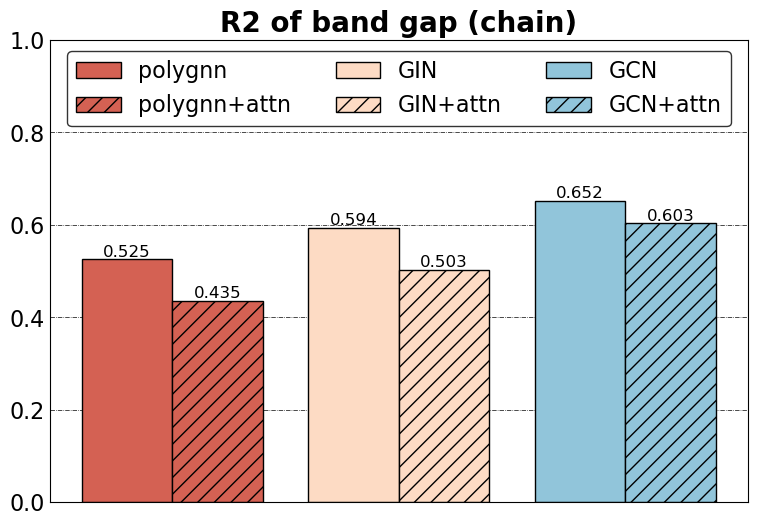

In [59]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import MultipleLocator
x = np.arange(1)
# y1 = np.array([0.857])
# y2 = np.array([0.901])
# y3 = np.array([0.714])
# y4 = np.array([0.803])
# y5 = np.array([0.662])
# y6 = np.array([0.746])
y1 = np.array([0.525])
y2 = np.array([0.435])
y3 = np.array([0.674])
y4 = np.array([0.503])
y5 = np.array([0.652])
y6 = np.array([0.529])
# error1 = np.array([0.0006])
# error3 = np.array([0.0003])
# error4 = np.array([0.0010])
# error2 = np.array([0.0006])


bar_width = 0.05

fig, ax = plt.subplots(figsize=(9,6))
rects1 = ax.bar(x - bar_width*6/2, y1, bar_width, capsize=5, edgecolor='black', label='polygnn',color=(212/255,97/255,83/255))
rects2 = ax.bar(x - bar_width*4/2, y2, bar_width,hatch='//', capsize=5, edgecolor='black', label='polygnn+attn',color=(212/255,97/255,83/255))
rects3 = ax.bar(x - bar_width/2, y3, bar_width, capsize=5, label='GIN', edgecolor='black',color=(253/255,219/255,196/255))
rects4 = ax.bar(x + bar_width/2, y4, bar_width, capsize=5,hatch='//' , edgecolor='black',label='GIN+attn',color=(253/255,219/255,196/255))
rects5 = ax.bar(x + bar_width*4/2, y5, bar_width, capsize=5, label='GCN', edgecolor='black',color=(145/255,197/255,218/255))
rects6 = ax.bar(x + bar_width*6/2, y6, bar_width, capsize=5,hatch='//' , edgecolor='black',label='GCN+attn',color=(145/255,197/255,218/255))


ax.set_xticks(x)
ax.set_xticklabels([''])

# 字体为16px大小，刻度线长度为0
ax.tick_params(labelsize=16,length=0)
# plt.box(False)
plt.ylim(0,1)
# 设置y轴网格线
ax.yaxis.grid(linewidth=0.5,color='black',linestyle='-.', markevery=5)
# 将网格线置于底层，
ax.set_axisbelow(True)
ax.yaxis.set_ticks([0, 0.2,0.4,0.6, 0.8,1])

ax.set_xlabel('')
ax.set_ylabel('')
# 将0处设为空字符串，其他地方加上k
# ax.set_yticklabels([" ","5k","10k","15k","20k"])
for i in range(1,7):
    for rect, label in zip(eval(f"rects{i}"), eval(f"y{i}")):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2, height, round(label, 3),
                ha='center', va='bottom', fontsize=12, color='black')
ax.set_title('RMSE of band gap (chain)',fontsize=20,fontweight='bold')

ax.legend(loc='upper center',  ncol=3, fontsize=16,edgecolor="black")

plt.savefig('/home/chenlidong/polyAttn/notebooks/1111111.png')
# plt.show()


In [ ]:
import torch
from torch_geometric.data import Data
import torch
from torch_geometric.data import Data

num_nodes = 100  # 假设有100个节点
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()

data = Data(edge_index=edge_index)

num_nodes = 100  # 假设有100个节点
edge_index = torch.combinations(torch.arange(num_nodes), r=2).t().contiguous()

data = Data(edge_index=edge_index)


: 